In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" #set cores for numpy
import numpy as np
import tensorflow as tf
import json
tf.get_logger().setLevel('ERROR') #no info and warnings are printed 
tf.config.threading.set_inter_op_parallelism_threads(1) #set cores for TF
tf.config.threading.set_intra_op_parallelism_threads(1)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.set_visible_devices([], 'GPU') #runs the code without GPU
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import time
from pathlib import Path
import matplotlib as mpl
plt.style.use('dark_background')

#Latex
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Handling

In [2]:
upsample = 1
Re       = 30
data_len = 300000
transient = 10000

Nx = 48
Nu = 2
# Generate this from Gen_data.ipynb
fln = '/data/ar994/Python/data/Kolmogorov/Kolmogorov_0.1_48_30.0_100100_32.h5'
hf  = h5py.File(fln,'r')
dt  = 0.1
U   = np.array(hf.get('U')[transient:transient+data_len:upsample], dtype=np.float32)
hf.close()

In [3]:
N_x     = U.shape[1]
N_y     = U.shape[2]

print('U-shape:',U.shape, dt)

def split_data(U, b_size, n_batches):
    
    '''
    Splits the data in batches. Each batch is created by sampling the signal with interval
    equal to n_batches
    '''
    data   = np.zeros((n_batches, b_size, U.shape[1], U.shape[2], U.shape[3]))    
    for j in range(n_batches):
        data[j] = U[::skip][j::n_batches].copy()

    return data

b_size      = 50   #batch_size
n_batches   = 500  #number of batches
val_batches = 50   #int(n_batches*0.2) # validation set size is 0.2 the size of the training set
skip        = 10

#print(b_size*n_batches*skip*dt*upsample)

print('Train Data%  :',b_size*n_batches*skip/U.shape[0]) #how much of the data we are using for training
print('Val   Data%  :',b_size*val_batches*skip/U.shape[0])

# training data
U_tt        = np.array(U[:b_size*n_batches*skip].copy())            #to be used for random batches
U_train     = split_data(U_tt, b_size, n_batches).astype('float32') #to be used for randomly shuffled batches
# validation data
U_vv        = np.array(U[b_size*n_batches*skip:
                         b_size*n_batches*skip+b_size*val_batches*skip].copy())
U_val       = split_data(U_vv, b_size, val_batches).astype('float32')             
del U_vv, U_tt

U-shape: (300000, 48, 48, 2) 0.1
Train Data%  : 0.8333333333333334
Val   Data%  : 0.08333333333333333


## Autoencoder functions

In [4]:
@tf.function #this creates the tf graph
def model(inputs, enc_mods, dec_mods, is_train=False):
    
    '''
    Multiscale autoencoder, taken from Hasegawa 2020. The contribution of the CNNs at different
    scales are simply summed.
    '''
        
    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)
            
    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)
        
    return encoded, decoded

@tf.function #this creates the tf graph
def train_step(inputs, enc_mods, dec_mods, train=True):
    
    """
    Trains the model by minimizing the loss between input and output
    """
    
    # autoencoded field
    decoded  = model(inputs, enc_mods, dec_mods, is_train=train)[-1]

    # loss with respect to the data
    loss     = Loss_Mse(inputs, decoded)

    # compute and apply gradients inside tf.function environment for computational efficiency
    if train:
        # create a variable with all the weights to perform gradient descent on
        # appending lists is done by plus sign
        varss    = [] #+ Dense.trainable_weights
        for enc_mod in enc_mods:
            varss  += enc_mod.trainable_weights
        for dec_mod in dec_mods:
            varss +=  dec_mod.trainable_weights
        
        grads   = tf.gradients(loss, varss)
        optimizer.apply_gradients(zip(grads, varss))
    
    return loss

In [5]:
class PerPad2D(tf.keras.layers.Layer):
    """
    Periodic Padding layer
    """
    def __init__(self, padding=1, asym=False, **kwargs):
        self.padding = padding
        self.asym    = asym
        super(PerPad2D, self).__init__(**kwargs)
        
    def get_config(self): #needed to be able to save and load the model with this layer
        config = super(PerPad2D, self).get_config()
        config.update({
            'padding': self.padding,
            'asym': self.asym,
        })
        return config

    def call(self, x):
        return periodic_padding(x, self.padding, self.asym)

def periodic_padding(image, padding=1, asym=False):
    '''
    Create a periodic padding (same of np.pad('wrap')) around the image, 
    to mimic periodic boundary conditions.
    When asym=True on the right and lower edges an additional column/row is added
    '''
        
    if asym:
        lower_pad = image[:,:padding+1,:]
    else:
        lower_pad = image[:,:padding,:]
    
    if padding != 0:
        upper_pad     = image[:,-padding:,:]
        partial_image = tf.concat([upper_pad, image, lower_pad], axis=1)
    else:
        partial_image = tf.concat([image, lower_pad], axis=1)
        
    if asym:
        right_pad = partial_image[:,:,:padding+1] 
    else:
        right_pad = partial_image[:,:,:padding]
    
    if padding != 0:
        left_pad = partial_image[:,:,-padding:]
        padded_image = tf.concat([left_pad, partial_image, right_pad], axis=2)
    else:
        padded_image = tf.concat([partial_image, right_pad], axis=2)

    return padded_image

## Create the model

In [6]:
# define the model
# we do not have pooling and upsampling, instead we use stride=2

lat_dep       = 2                          #latent space depth
n_fil         = [6,12,24,lat_dep]          #number of filters ecnoder
n_dec         = [24,12,6,3]                #number of filters decoder
N_parallel    = 3                          #number of parallel CNNs for multiscale
ker_size      = [(3,3), (5,5), (7,7)]      #kernel sizes
N_layers      = 4                          #number of layers in every CNN
act           = 'tanh'                     #activation function

pad_enc       = 'valid'         #no padding in the conv layer
pad_dec       = 'valid'
p_size        = [0,1,2]         #stride = 2 periodic padding size          
p_fin         = [1,2,3]         #stride = 1 periodic padding size
p_dec         = 1               #padding in the first decoder layer
p_crop        = U.shape[1]      #crop size of the output equal to input size


#initialize the encoders and decoders with different kernel sizes    
enc_mods      = [None]*(N_parallel)
dec_mods      = [None]*(N_parallel)    
for i in range(N_parallel):
    enc_mods[i] = tf.keras.Sequential(name='Enc_' + str(i))
    dec_mods[i] = tf.keras.Sequential(name='Dec_' + str(i))


#generate encoder layers    
for j in range(N_parallel):
    for i in range(N_layers):      

        #stride=2 padding and conv
        enc_mods[j].add(PerPad2D(padding=p_size[j], asym=True,
                                          name='Enc_' + str(j)+'_PerPad_'+str(i)))
        enc_mods[j].add(tf.keras.layers.Conv2D(filters = n_fil[i], kernel_size=ker_size[j],
                                      activation=act, padding=pad_enc, strides=2,
                        name='Enc_' + str(j)+'_ConvLayer_'+str(i)))

        #stride=1 padding and conv
        if i<N_layers-1:
            enc_mods[j].add(PerPad2D(padding=p_fin[j], asym=False,
                                                      name='Enc_'+str(j)+'_Add_PerPad1_'+str(i)))
            enc_mods[j].add(tf.keras.layers.Conv2D(filters=n_fil[i],
                                                    kernel_size=ker_size[j], 
                                                activation=act,padding=pad_dec,strides=1,
                                                    name='Enc_'+str(j)+'_Add_Layer1_'+str(i)))        


#explicitly obtain the size of the latent space
N_1      = enc_mods[-1](U_train[0]).shape
N_latent = N_1[-3]*N_1[-2]*N_1[-1]


#generate decoder layers            
for j in range(N_parallel):

    for i in range(N_layers):

        #initial padding of latent space
        if i==0: 
            dec_mods[j].add(PerPad2D(padding=p_dec, asym=False,
                                          name='Dec_' + str(j)+'_PerPad_'+str(i))) 
        
        #Transpose convolution with stride = 2 
        dec_mods[j].add(tf.keras.layers.Conv2DTranspose(filters = n_dec[i],
                                       output_padding=None,kernel_size=ker_size[j],
                                      activation=act, padding=pad_dec, strides=2,
                            name='Dec_' + str(j)+'_ConvLayer_'+str(i)))
        
        #Convolution with stride=1
        if  i<N_layers-1:       
            dec_mods[j].add(tf.keras.layers.Conv2D(filters=n_dec[i],
                                        kernel_size=ker_size[j], 
                                       activation=act,padding=pad_dec,strides=1,
                                      name='Dec_' + str(j)+'_ConvLayer1_'+str(i)))

    #crop and final linear convolution with stride=1
    dec_mods[j].add(tf.keras.layers.CenterCrop(p_crop + 2*p_fin[j],
                                                   p_crop+ 2*p_fin[j],
                            name='Dec_' + str(j)+'_Crop_'+str(i)))
    dec_mods[j].add(tf.keras.layers.Conv2D(filters=U.shape[3],
                                            kernel_size=ker_size[j], 
                                            activation='linear',padding=pad_dec,strides=1,
                                              name='Dec_' + str(j)+'_Final_Layer'))


# run the model once to print summary
enc0, dec0 = model(U_train[0], enc_mods, dec_mods)
print('latent   space size:', N_latent)
print('physical space size:', U[0].flatten().shape)
print('')
for j in range(3):
    enc_mods[j].summary()
for j in range(3):
    dec_mods[j].summary()    

latent   space size: 18
physical space size: (4608,)

Model: "Enc_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Enc_0_PerPad_0 (PerPad2D)    (50, 49, 49, 2)           0         
_________________________________________________________________
Enc_0_ConvLayer_0 (Conv2D)   (50, 24, 24, 6)           114       
_________________________________________________________________
Enc_0_Add_PerPad1_0 (PerPad2 (50, 26, 26, 6)           0         
_________________________________________________________________
Enc_0_Add_Layer1_0 (Conv2D)  (50, 24, 24, 6)           330       
_________________________________________________________________
Enc_0_PerPad_1 (PerPad2D)    (50, 25, 25, 6)           0         
_________________________________________________________________
Enc_0_ConvLayer_1 (Conv2D)   (50, 12, 12, 12)          660       
_________________________________________________________________
Enc_0_A

## Train the model

Epoch 0 ; Train_Loss 0.022422693252563478 ; Val_Loss 0.002179282903671265 ; Ratio 0.09719095200225861
Time per epoch 335449602.01703775

Saving Model..
Epoch 5 ; Train_Loss 0.00038510209321975707 ; Val_Loss 0.000620986633002758 ; Ratio 1.6125246887411602
Time per epoch 8.71099305152893

Saving Model..
Epoch 10 ; Train_Loss 0.00016697782278060912 ; Val_Loss 0.0001761414110660553 ; Ratio 1.054879073956343
Time per epoch 8.871652317047118

Saving Model..
Epoch 15 ; Train_Loss 0.0002622913718223572 ; Val_Loss 0.00010765273123979569 ; Ratio 0.4104318433802922
Time per epoch 8.975719356536866

Saving Model..
Epoch 20 ; Train_Loss 0.00010481956601142883 ; Val_Loss 7.67415901646018e-05 ; Ratio 0.7321303940166515
Time per epoch 9.046130514144897



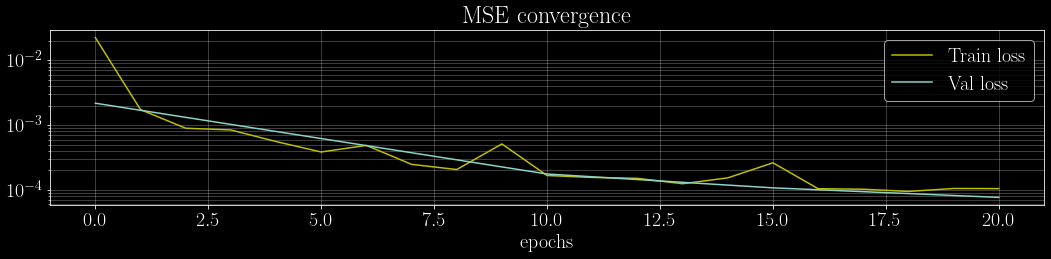

Saving Model..
Epoch 25 ; Train_Loss 7.047609239816665e-05 ; Val_Loss 6.325511261820793e-05 ; Ratio 0.8975400091826521
Time per epoch 9.301438140869141

Epoch 30 ; Train_Loss 9.207625687122345e-05 ; Val_Loss 0.00010000428184866905 ; Ratio 1.0861028157186454
Time per epoch 9.167722940444946

Saving Model..
Epoch 35 ; Train_Loss 6.631997227668763e-05 ; Val_Loss 4.96137049049139e-05 ; Ratio 0.7480959837848695
Time per epoch 9.25361008644104

Saving Model..
Epoch 40 ; Train_Loss 5.0282642245292664e-05 ; Val_Loss 4.503252916038036e-05 ; Ratio 0.8955879633512337
Time per epoch 9.401617431640625



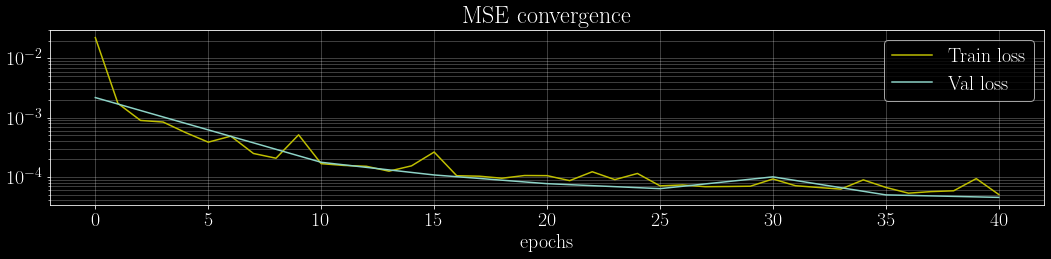

Epoch 45 ; Train_Loss 4.4818196445703505e-05 ; Val_Loss 5.114255007356405e-05 ; Ratio 1.1411112924975104
Time per epoch 9.3961350440979

Epoch 50 ; Train_Loss 9.233332425355911e-05 ; Val_Loss 4.634647164493799e-05 ; Ratio 0.5019473956950218
Time per epoch 9.238901281356812

Epoch 55 ; Train_Loss 4.235938936471939e-05 ; Val_Loss 4.5681069605052474e-05 ; Ratio 1.0784166223864329
Time per epoch 9.241946411132812

Epoch 60 ; Train_Loss 4.7457337379455566e-05 ; Val_Loss 7.493957877159118e-05 ; Ratio 1.579093621970304
Time per epoch 9.301606273651123



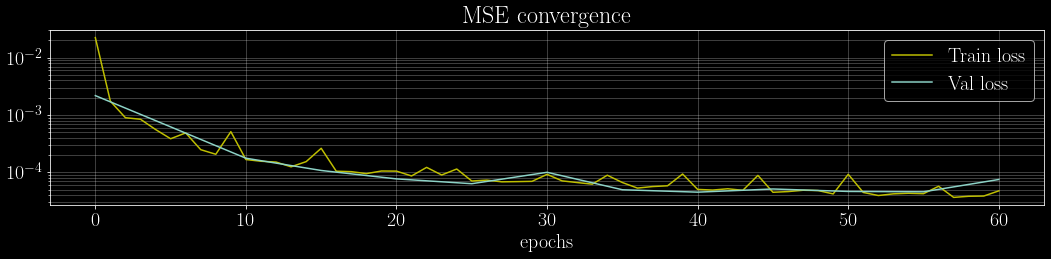

Saving Model..
Epoch 65 ; Train_Loss 3.3696401864290235e-05 ; Val_Loss 2.9789733234792946e-05 ; Ratio 0.8840627362757867
Time per epoch 9.372577953338624

Epoch 70 ; Train_Loss 3.476059809327126e-05 ; Val_Loss 3.508512396365404e-05 ; Ratio 1.0093360266561582
Time per epoch 9.491496562957764

Epoch 75 ; Train_Loss 3.2876737415790555e-05 ; Val_Loss 3.3564260229468344e-05 ; Ratio 1.0209121362920754
Time per epoch 9.456291198730469

Epoch 80 ; Train_Loss 3.014150820672512e-05 ; Val_Loss 3.95918870344758e-05 ; Ratio 1.3135337078335758
Time per epoch 9.489735984802246



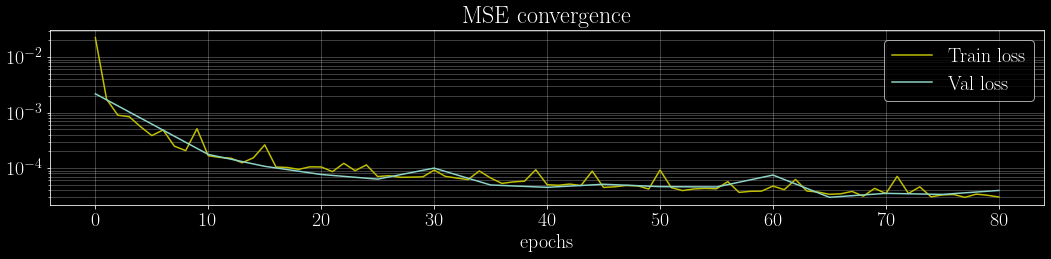

Saving Model..
Epoch 85 ; Train_Loss 2.658342383801937e-05 ; Val_Loss 2.774565014988184e-05 ; Ratio 1.043719963197527
Time per epoch 9.598370599746705

Saving Model..
Epoch 90 ; Train_Loss 2.9297946020960808e-05 ; Val_Loss 2.5783085729926823e-05 ; Ratio 0.8800304878533353
Time per epoch 9.532798862457275

Epoch 95 ; Train_Loss 2.9459098353981972e-05 ; Val_Loss 3.1576240435242656e-05 ; Ratio 1.0718671717586534
Time per epoch 9.483936595916749

Saving Model..
Epoch 100 ; Train_Loss 2.6983030140399934e-05 ; Val_Loss 2.3529739119112493e-05 ; Ratio 0.872019895344628
Time per epoch 9.541956520080566



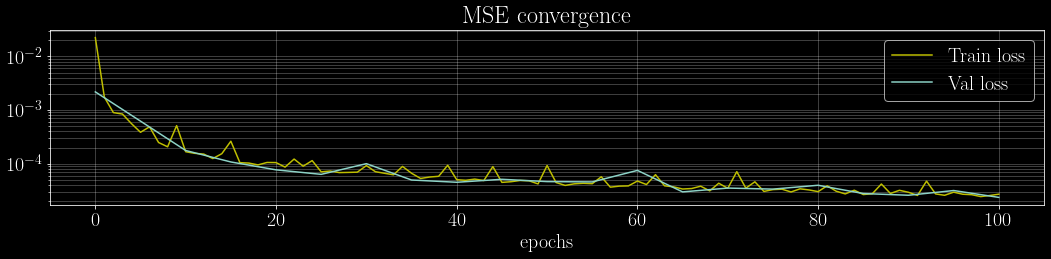

In [7]:
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"]  = 20

path = './data/48_RE30_'+str(N_latent) #to save model

rng = np.random.default_rng() #random generator for later shufflinh

Loss_Mse    = tf.keras.losses.MeanSquaredError()

n_epochs    = 101 #number of epochs

#define optimizer and initial learning rate   
optimizer  = tf.keras.optimizers.Adam(amsgrad=True) #amsgrad True for better convergence
l_rate     = 0.002
optimizer.learning_rate = l_rate

lrate_update = True #flag for l_rate updating
lrate_mult   = 0.75 #decrease by this factore the l_rate 
N_lr         = 100  #number of epochs before which the l_rate is not updated

# quantities to check and store the training and validation loss and the training goes on
old_loss      = np.zeros(n_epochs) #needed to evaluate training loss convergence to update l_rate
tloss_plot    = np.zeros(n_epochs) #training loss
vloss_plot    = np.zeros(n_epochs) #validation loss
old_loss[0]  = 1e6 #initial value has to be high
N_check      = 5   #each N_check epochs we check convergence and validation loss
patience     = 200 #if the val_loss has not gone down in the last patience epochs, early stop
last_save    = patience

t            = 1 # initial (not important value) to monitor the time of the training

for epoch in range(n_epochs):
    
    if epoch - last_save > patience: break #early stop
                
    #Perform gradient descent for all the batches every epoch
    loss_0 = 0
    rng.shuffle(U_train, axis=0) #shuffle batches
    for j in range(n_batches):
            loss    = train_step(U_train[j], enc_mods, dec_mods)
            loss_0 += loss
    
    #save train loss
    tloss_plot[epoch]  = loss_0.numpy()/n_batches     
    
    # every N epochs checks the convergence of the training loss and val loss
    if (epoch%N_check==0):
        
        #Compute Validation Loss
        loss_val        = 0
        for j in range(val_batches):
            loss        = train_step(U_val[j], enc_mods, dec_mods,train=False)
            loss_val   += loss
        
        #save validation loss
        vloss_plot[epoch]  = loss_val.numpy()/val_batches 
        
        # Decreases the learning rate if the training loss is not going down with respect to 
        # N_lr epochs before
        if epoch > N_lr and lrate_update:
            #check if the training loss is smaller than the average training loss N_lr epochs ago
            tt_loss   = np.mean(tloss_plot[epoch-N_lr:epoch])
            if tt_loss > old_loss[epoch-N_lr]:
                #if it is larger, load optimal val loss weights and decrease learning rate
                print('LOADING MINIMUM')
                for i in range(N_parallel):
                    enc_mods[i].load_weights(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'_weights.h5')
                    dec_mods[i].load_weights(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'_weights.h5')

                optimizer.learning_rate = optimizer.learning_rate*lrate_mult
                optimizer.set_weights(min_weights)
                print('LEARNING RATE CHANGE', optimizer.learning_rate.numpy(), deviation)
                old_loss[epoch-N_lr:epoch] = 1e6 #so that l_rate is not changed for N_lr steps
        
        #store current loss
        old_loss[epoch] = tloss_plot[epoch].copy()
        
        #save best model (the one with minimum validation loss)
        if epoch > 1 and vloss_plot[epoch] < \
                         (vloss_plot[:epoch-1][np.nonzero(vloss_plot[:epoch-1])]).min():
        
            #saving the model weights
            print('Saving Model..')
            Path(path).mkdir(parents=True, exist_ok=True) #creates directory even when it exists
            for i in range(N_parallel):
                enc_mods[i].save(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5')
                dec_mods[i].save(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5')
                enc_mods[i].save_weights(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'_weights.h5')
                dec_mods[i].save_weights(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'_weights.h5')
            
            #saving optimizer parameters
            min_weights = optimizer.get_weights()
            hf = h5py.File(path + '/opt_weights.h5','w')
            for i in range(len(min_weights)):
                hf.create_dataset('weights_'+str(i),data=min_weights[i])
            hf.create_dataset('length', data=i)
            hf.create_dataset('l_rate', data=optimizer.learning_rate)  
            hf.close()
            
            last_save = epoch #store the last time the val loss has decreased for early stop

        # Print loss values and training time (per epoch)
        print('Epoch', epoch, '; Train_Loss', tloss_plot[epoch], 
              '; Val_Loss', vloss_plot[epoch],  '; Ratio', (vloss_plot[epoch])/(tloss_plot[epoch]))
        print('Time per epoch', (time.time()-t)/N_check)
        print('')
        
        t = time.time()
        
    if (epoch%20==0) and epoch != 0:    
        #plot convergence of training and validation loss (to visualise convergence during training)
        plt.title('MSE convergence')
        plt.yscale('log')
        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
        plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
        plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0])*N_check,
                 vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
        plt.xlabel('epochs')
        plt.legend()    
        plt.tight_layout()
        plt.show()

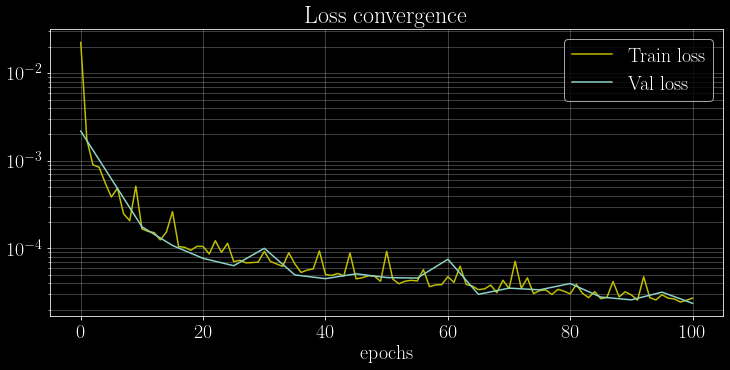

In [8]:
#save loss convergence plot
hf = h5py.File(path + '/loss_conv.h5','w')
hf.create_dataset('t_loss',  data=tloss_plot[np.nonzero(tloss_plot)])
hf.create_dataset('v_loss',  data=vloss_plot[np.nonzero(vloss_plot)]) 
hf.create_dataset('N_check', data=N_check)
hf.close()
            
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"]  = 20
        
#plot convergence of training and validation loss
plt.figure()
plt.title('Loss convergence')
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.plot(tloss_plot[np.nonzero(tloss_plot)], 'y', label='Train loss')
plt.plot(np.arange(np.nonzero(vloss_plot)[0].shape[0])*N_check,
         vloss_plot[np.nonzero(vloss_plot)], label='Val loss')
plt.xlabel('epochs')
plt.legend()
plt.tight_layout(pad=0.1)
plt.savefig(path+'/loss_convergence.pdf')
plt.show()

## Visualise error in flowfield in test set

NMAE:  0.001150409
NMAE:  0.0011588788
NMAE:  0.0012422451
NMAE:  0.0013252925
NMAE:  0.001125741


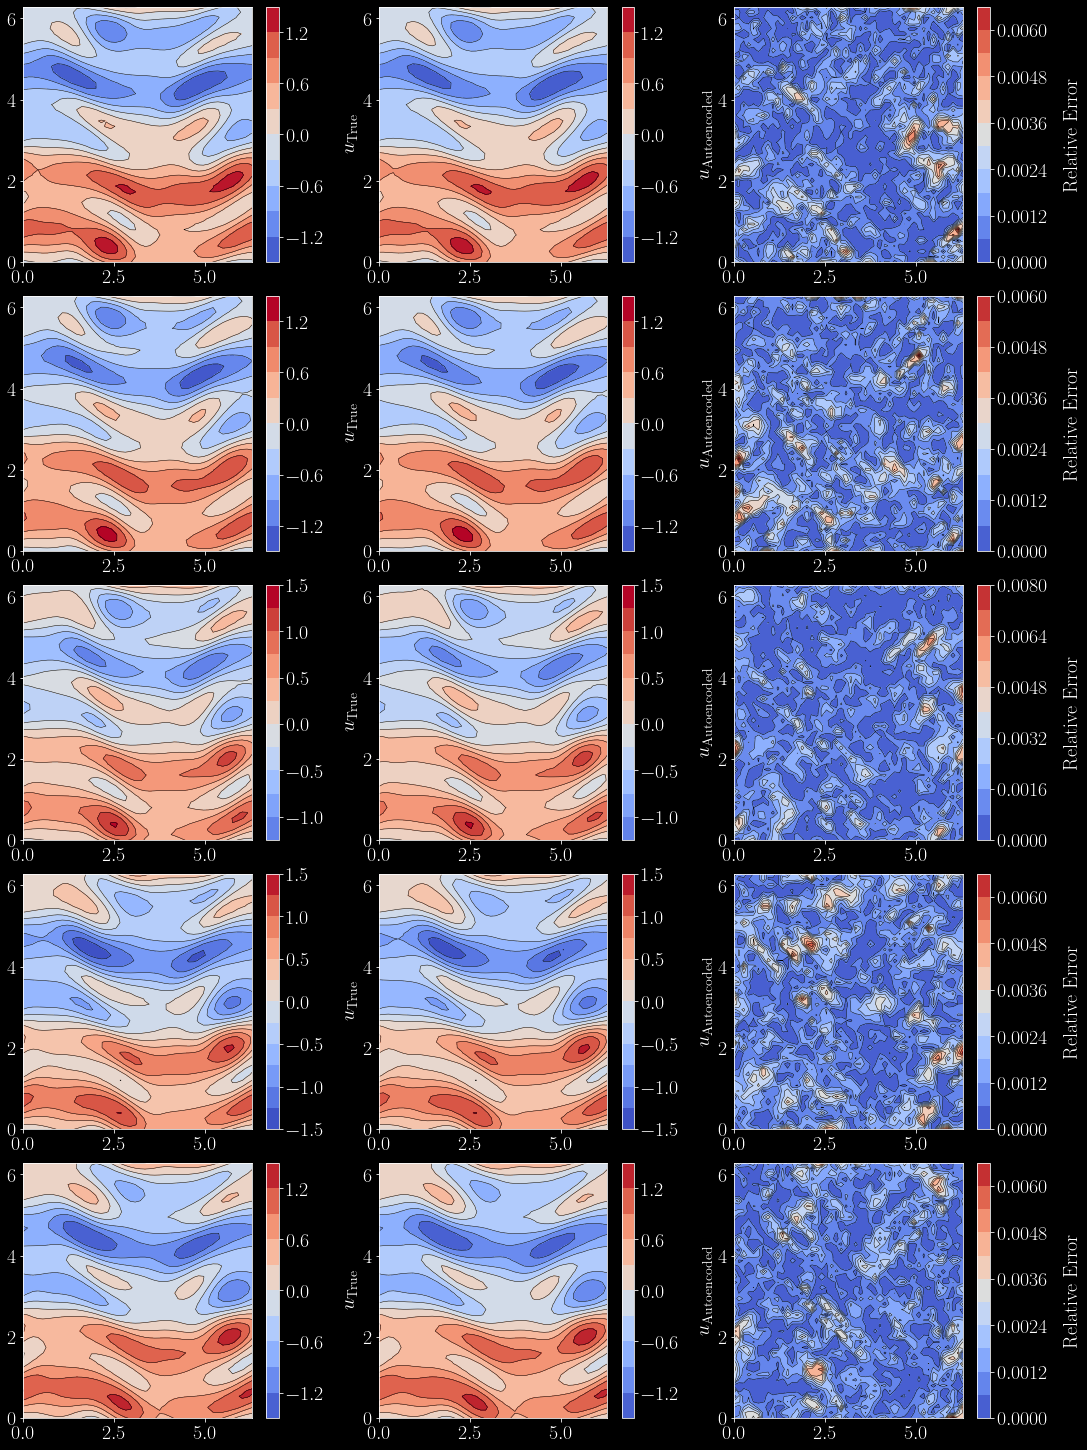

In [9]:
#load model for the test set
path = './data/48_RE30_'+str(N_latent)
# Load best model
#how to load saved model
a = [None]*N_parallel
b = [None]*N_parallel
for i in range(N_parallel):
    a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5', 
                                          custom_objects={"PerPad2D": PerPad2D})
for i in range(N_parallel):
    b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5',
                                          custom_objects={"PerPad2D": PerPad2D})

#grid
X       = np.linspace(0,2*np.pi,N_x) 
Y       = np.linspace(0,2*np.pi,N_y) 
XX      = np.meshgrid(X, Y, indexing='ij')

#plot n snapshots and their reconstruction in the test set.
n       = 5
plt.rcParams["figure.figsize"] = (15,4*n)
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(n,3)

start   = b_size*n_batches*skip+b_size*val_batches*skip #start after validation set

for i in range(n):
    
    #truth
    plt.subplot(n,3,i*3+1)
    
    skips = 50
    
    #snapshots to plot
    u      = U[start+500+i*skips:start+501+i*skips].copy()      
    vmax   = u.max()
    vmin   = u.min()

    CS0    = plt.contourf(XX[0], XX[1],u[0,:,:,0],
                          levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{True}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u[0,:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    #autoencoded
    plt.subplot(n,3,i*3+2)

    u_dec  = model(u,a,b)[1][0].numpy()
    CS     = plt.contourf(XX[0],XX[1],u_dec[:,:,0],
                        levels=10,cmap='coolwarm',vmin=vmin, vmax=vmax)
    cbar   = plt.colorbar()
    cbar.set_label('$u_{\mathrm{Autoencoded}}$',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_dec[:,:,0],
                         levels=10,colors='black',linewidths=.5, linestyles='solid',
                         vmin=vmin, vmax=vmax)
    
    #error
    plt.subplot(n,3,i*3+3)

    u_err  = np.abs(u_dec-u[0])/(vmax-vmin)
    print('NMAE: ', u_err[:,:,0].mean())

    CS     = plt.contourf(XX[0], XX[1],u_err[:,:,0],levels=10,cmap='coolwarm')
    cbar   = plt.colorbar()
    cbar.set_label('Relative Error',labelpad=15)
    CS     = plt.contour(XX[0], XX[1],u_err[:,:,0],levels=10,colors='black',linewidths=.5, 
                         linestyles='solid')

fig.tight_layout(pad=0.1)
plt.savefig(path+'/Autoencoder_error.pdf')
plt.show()

## Save encoded data for ESN training

In [10]:
# save the encoded data for the ESN (too much memory used for GPU)
N_pos     = 5000 #split in k interval of N_pos length needed to process long timeseries
k         = 75
transient = 10000
N_len = k*N_pos
fln      = '/data/ar994/Python/data/Kolmogorov/Kolmogorov_0.1_48_30.0_100100_32.h5'
hf       = h5py.File(fln,'r')
dt       = 0.1
U        = np.array(hf.get('U')[transient:transient+N_len], dtype=np.float32)
hf.close()

N_x      = U.shape[1]
N_y      = U.shape[2]

In [12]:
Latents  = [18]
Re       = 30

for N_latent in Latents:
    path = './data/48_RE30_'+str(N_latent)
    a = [None]*N_parallel
    b = [None]*N_parallel
    for i in range(N_parallel):
        a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5', 
                                              custom_objects={"PerPad2D": PerPad2D})
    for i in range(N_parallel):
        b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5',
                                              custom_objects={"PerPad2D": PerPad2D})

    N_1   = [3,3,N_latent//9]
    U_enc = np.zeros((N_len, N_1[0], N_1[1], N_1[2]))
    #encode all the data to provide time series in latent space for the ESN
    for i in range(k):
        U_enc[i*N_pos:(i+1)*N_pos]= model(U[i*N_pos:(i+1)*N_pos], a, b)[0]

    fln = './data/48_Encoded_data_Re30_' \
                + str(N_latent) +'.h5'
    hf = h5py.File(fln,'w')
    hf.create_dataset('U_enc'      ,data=U_enc)  
    hf.close()
    print(fln)

./data/48_Encoded_data_Re30_18.h5


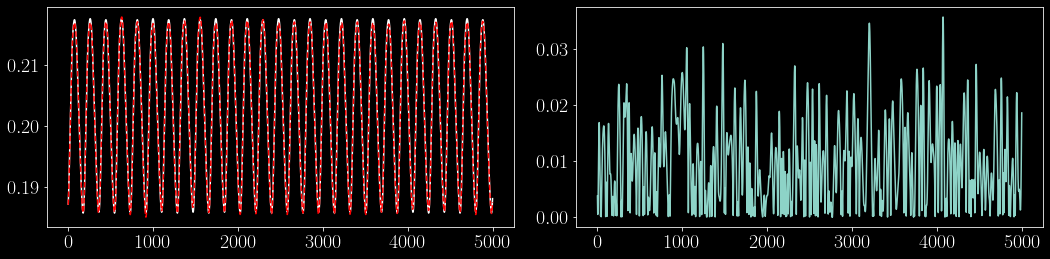

0.010208535055265935


In [14]:
def gradient(U,dx,dy,n_splits):
    '''Returns dissipation of U, done in n_splits'''
    
    shapes    = np.array(U.shape)
    shapes[0] = shapes[0]//n_splits
    dU_dx     = np.empty(shapes)
    dU_dy     = np.empty(shapes)
    D         = np.empty(shapes[0]*n_splits)
    
    for i in np.arange(n_splits):
        
        for j in range(shapes[1]):
            dU_dx[:,j] = (U[i*shapes[0]:(i+1)*shapes[0],(j+1)%shapes[1]] - \
                          U[i*shapes[0]:(i+1)*shapes[0],j-1])/(2*dx)
        for k in range(shapes[2]):
            dU_dy[:,:,k] = (U[i*shapes[0]:(i+1)*shapes[0],:,(k+1)%shapes[2]] - \
                            U[i*shapes[0]:(i+1)*shapes[0],:,k-1])/(2*dy)
            
        D[i*shapes[0]:(i+1)*shapes[0]] =  np.mean(dU_dx**2+dU_dy**2,
                                            axis=(1,2,3))/Re*4
              
    return D
        
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"] = 20

#plot average dissipation rate
plt.subplot(121)
leng      = 5000
dx        = 2*np.pi/(N_x-1)
DD        = gradient(U[-leng:],dx,dx,1) #true
U_dec     = model(U[-leng:], a, b)[1]
DD_enc    = gradient(U_dec,dx,dx,1) #autoencoded
plt.plot(DD,'w')
plt.plot(DD_enc,'r--')

#plot error
plt.subplot(122)
plt.plot(np.abs(DD_enc-DD)/(DD.max()-DD.min()))
plt.tight_layout()
plt.show()
print(np.mean(np.abs(DD_enc-DD)/(DD.max()-DD.min())))
